# <span style="color:green"><center> Gráficas de las estaciones meteorológicas </center></span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_venn import venn2
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry.point import Point

In [2]:
pcp_col = pd.read_excel('/home/fm/Downloads/pcp_col.xlsx')
#pcp_col = pcp_col.melt(id_vars = ['ID', 'X', 'Y'], var_name = 'Fecha', value_name = 'Valor').pivot_table('Valor', ['Fecha'], 'ID')
pcp_col['geometry'] = gpd.points_from_xy(pcp_col['X'], pcp_col['Y'])
gdf_pcp_col = gpd.GeoDataFrame(pcp_col[['ID', 'geometry']], geometry='geometry', crs = 'epsg:4326')
gdf_pcp_col.head()
#gdf_pcp_col = gpd.GeoDataFrame(pcp_col[['ID', 'X', 'Y']])

,ID,geometry
0,17015010,POINT (-81.70389 12.58694)
1,17025020,POINT (-81.35000 13.35000)
2,15015050,POINT (-74.22889 11.12833)
3,14015080,POINT (-75.51603 10.44725)
4,29045190,POINT (-74.77978 10.88334)


In [3]:
tmed_col = pd.read_excel('/home/fm/Downloads/tmed_col2.xlsx', sheet_name= 'tmed_col')
tmed_col['geometry'] = gpd.points_from_xy(tmed_col['X'], tmed_col['Y'])
gdf_tmed_col = gpd.GeoDataFrame(tmed_col[['ID', 'geometry']], geometry='geometry', crs = 'epsg:4326')
gdf_tmed_col.head()

,ID,geometry
0,11045010,POINT (-76.64386 5.69056)
1,11115020,POINT (-76.02972 6.75806)
2,12015020,POINT (-76.65139 7.82611)
3,12015070,POINT (-76.71783 7.81667)
4,12045020,POINT (-76.22550 9.07217)


In [4]:
gdf_pcp_tmed  = gdf_pcp_col.merge(gdf_tmed_col, how="outer", on='geometry', indicator=True)
gdf_pcp_tmed['met'] = np.where(gdf_pcp_tmed['_merge'] == 'left_only', 'precipitación', np.where(gdf_pcp_tmed['_merge'] == 'both', 'precipitación y temperatura', 'temperatura'))
gdf_pcp_tmed.groupby('met')['met'].count()

met
precipitación                  648
precipitación y temperatura    198
temperatura                     10
Name: met, dtype: int64

In [5]:
gdf_pcp_tmed['geometry'].nunique()

856

In [6]:
gdf_pcp_col.dtypes

ID             int64
geometry    geometry
dtype: object

In [7]:
# https://geoportal.igac.gov.co/contenido/datos-abiertos-cartografia-y-geografia
shp_depto = gpd.read_file('Departamentos202208_shp/Depto.shp')
shp_depto_4326 = shp_depto.to_crs("EPSG:4326")
shp_depto_4326["perimetro"] = shp_depto_4326.boundary

In [8]:
outer = sjoin(gdf_pcp_tmed, shp_depto_4326, how = 'left')
outer = outer[pd.isna(outer['perimetro'])]
outer

,ID_x,geometry,ID_y,_merge,met,index_right,DeCodigo,DeNombre,DeArea,DeNorma,SHAPE_Leng,SHAPE_Area,perimetro
1,17025020.0,POINT (-81.35000 13.35000),17025020.0,both,precipitación y temperatura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
37,29040230.0,POINT (-74.96967 10.98833),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
90,15075030.0,POINT (-72.48017 11.78106),15075030.0,both,precipitación y temperatura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
190,37050010.0,POINT (-71.41972 7.03722),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
591,38027020.0,POINT (-67.83417 4.95694),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
625,47030020.0,POINT (-75.62972 0.04694),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
635,47040020.0,POINT (-74.38667 -0.55917),NaN,left_only,precipitación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [9]:
shp_join_gdf = sjoin(gdf_pcp_tmed, shp_depto_4326)
#shp_join_gdf.head()

In [10]:
color_dict = {'precipitación':'blue', 'precipitación y temperatura':'orange',
              'temperatura':'red'}
color_dict2 = {'precipitación':'blue', 'precipitación y temperatura':'orange'}

In [11]:
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
points = gpd.GeoSeries([Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

In [12]:
x, y, arrow_length = 0.1, 0.85, 0.1

<AxesSubplot: >

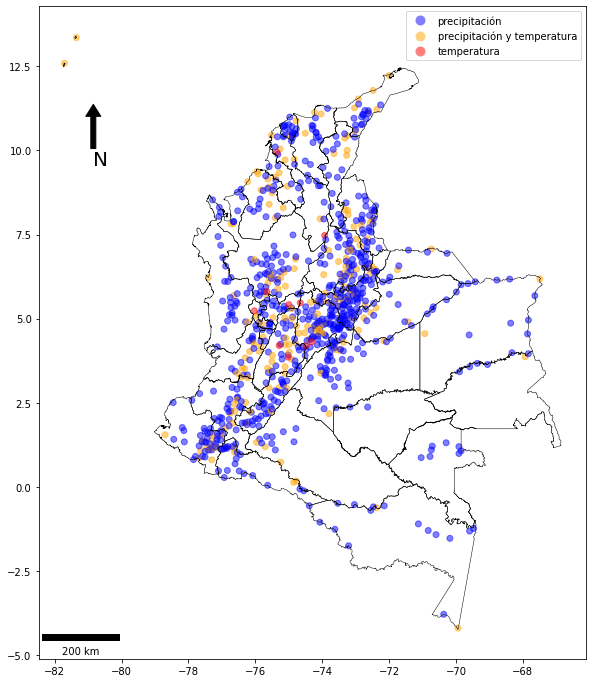

In [13]:
#axis = shp_depto_4326.plot(figsize = (20, 12))
axis = shp_depto_4326["perimetro"].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
axis.add_artist(ScaleBar(distance_meters, location='lower left'))
axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
              arrowprops=dict(facecolor='black', width=5, headwidth=15),
              ha='left', va='bottom', fontsize=20,
              xycoords=axis.transAxes)
shp_join_gdf.plot(ax = axis, column = 'met', alpha = 0.5, legend = True, cmap=colors.ListedColormap(list(color_dict.values()))) 
#outer.plot(ax = axis, color = 'black')
#outer.plot(ax = axis, column = 'met', cmap=colors.ListedColormap(list(color_dict2.values())))
outer.plot(ax = axis, column = 'met', alpha = 0.5, cmap=colors.ListedColormap(list(color_dict2.values())))

In [14]:
shp_join_gdf['Depto'] = shp_join_gdf['DeNombre']
shp_join_gdf = shp_join_gdf.set_index("Depto")
shp_depto_4326 = shp_depto_4326.set_index("DeNombre")

In [15]:
shp_mun = gpd.read_file('Municipios202208_shp/Munpio.shp') 
shp_mun_4326 = shp_mun.to_crs("EPSG:4326")
shp_mun_4326["perimetro"] = shp_mun_4326.boundary
#shp_mun_4326 = shp_mun_4326.set_index("DeNombre")

In [16]:
Cundi = shp_mun_4326.query("Depto == 'Cundinamarca'")
Cundi_stations = shp_join_gdf.loc["Cundinamarca", ["geometry", "met"]]

<AxesSubplot: >

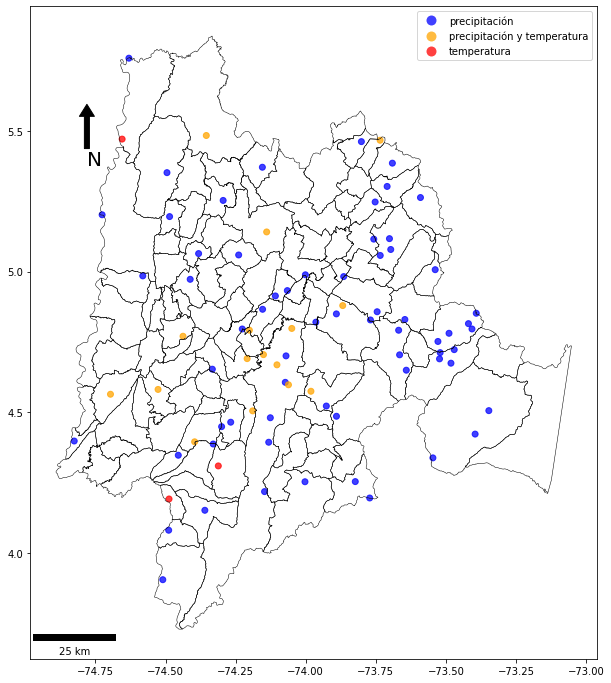

In [17]:
axis = Cundi['perimetro'].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
axis.add_artist(ScaleBar(distance_meters, location='lower left'))
axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
              arrowprops=dict(facecolor='black', width=5, headwidth=15),
              ha='left', va='bottom', fontsize=20,
              xycoords=axis.transAxes)
Cundi_stations.plot(ax = axis, alpha = 0.75, column = 'met', legend = True, cmap=colors.ListedColormap(list(color_dict.values())))

In [18]:
SAyP = shp_mun_4326.query("Depto == 'San Andrés y Providencia'")
#SAyP_stations = shp_join_pcp.loc["San Andrés Providencia y Santa Catalina", "geometry"]
SAyP_stations = gpd.GeoDataFrame(shp_join_gdf.query("DeCodigo == '88'"), geometry='geometry', crs = 'epsg:4326')

In [19]:
color_dict3 = {'precipitación y temperatura':'orange'}
x, y, arrow_length = 0.1, 0.85, 0.1

<AxesSubplot: >

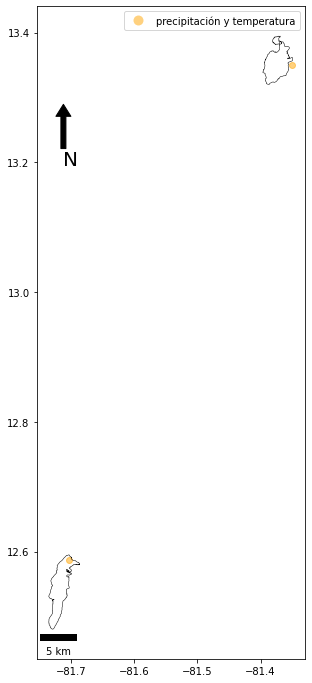

In [20]:
axis = SAyP['perimetro'].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
axis.add_artist(ScaleBar(distance_meters, location='lower left'))
axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
              arrowprops=dict(facecolor='black', width=5, headwidth=15),
              ha='left', va='bottom', fontsize=20,
              xycoords=axis.transAxes)
SAyP_stations.plot(ax = axis, column = 'met', alpha = 0.5, legend = True, cmap=colors.ListedColormap(list(color_dict3.values())))
outer[outer['ID_x']== 17025020].plot(ax = axis, column = 'met', alpha = 0.5, cmap=colors.ListedColormap(list(color_dict3.values())))

In [21]:
shp_join_gdf2 = shp_join_gdf.merge(outer[['ID_x', 'geometry', 'ID_y', '_merge', 'met']], how="outer", on=['ID_x', 'geometry', 'ID_y', '_merge', 'met']) # , indicator=True
#shp_join_gdf2 = sjoin(shp_join_gdf.drop('index_right', axis=1),outer.drop('index_right', axis=1), how = 'left')

In [22]:
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==17025020,'DeNombre'] = 'San Andrés Providencia y Santa Catalina'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==29040230, 'DeNombre'] = 'Atlántico'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==15075030, 'DeNombre'] = 'La Guajira'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==37050010, 'DeNombre'] = 'Arauca'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==38027020, 'DeNombre'] = 'Vichada'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==47030020, 'DeNombre'] = 'Putumayo'
shp_join_gdf2.loc[shp_join_gdf2['ID_x']==47040020, 'DeNombre'] = 'Amazonas'
shp_join_gdf2.loc[shp_join_gdf2['DeNombre']=='Area en Litigio Cauca - Huila', 'DeNombre'] = 'Cauca'

In [23]:
shp_join_gdf2.tail(7)
#shp_join_gdf2['ID_x'] = np.where(shp_join_gdf2['ID_x'] is None, shp_join_gdf2['ID_y'], shp_join_gdf2['ID_x']) #.group_by()[]

,ID_x,geometry,ID_y,_merge,met,index_right,DeCodigo,DeNombre,DeArea,DeNorma,SHAPE_Leng,SHAPE_Area,perimetro
849,17025020.0,POINT (-81.35000 13.35000),17025020.0,both,precipitación y temperatura,NaN,NaN,San Andrés Providencia y Santa Catalina,NaN,NaN,NaN,NaN,None
850,29040230.0,POINT (-74.96967 10.98833),NaN,left_only,precipitación,NaN,NaN,Atlántico,NaN,NaN,NaN,NaN,None
851,15075030.0,POINT (-72.48017 11.78106),15075030.0,both,precipitación y temperatura,NaN,NaN,La Guajira,NaN,NaN,NaN,NaN,None
852,37050010.0,POINT (-71.41972 7.03722),NaN,left_only,precipitación,NaN,NaN,Arauca,NaN,NaN,NaN,NaN,None
853,38027020.0,POINT (-67.83417 4.95694),NaN,left_only,precipitación,NaN,NaN,Vichada,NaN,NaN,NaN,NaN,None
854,47030020.0,POINT (-75.62972 0.04694),NaN,left_only,precipitación,NaN,NaN,Putumayo,NaN,NaN,NaN,NaN,None
855,47040020.0,POINT (-74.38667 -0.55917),NaN,left_only,precipitación,NaN,NaN,Amazonas,NaN,NaN,NaN,NaN,None


In [24]:
shp_join_gdf2['ID_x'] = np.where(pd.isna(shp_join_gdf2['ID_x']),shp_join_gdf2['ID_y'],shp_join_gdf2['ID_x'])

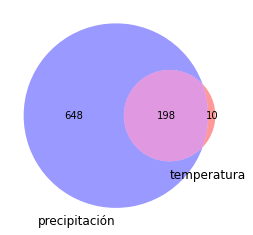

In [25]:
set1 = set(shp_join_gdf2['ID_x'][(shp_join_gdf2['met'].isin(['precipitación','precipitación y temperatura']))])
set2 = set(shp_join_gdf2['ID_x'][(shp_join_gdf2['met'].isin(['temperatura','precipitación y temperatura']))])
#set3 = set()

venn2([set1, set2], ('precipitación', 'temperatura'), ('blue', 'red') )

plt.show()

In [26]:
# Número de estaciones meteorlógicas por departamento
tbl_depto_met = pd.DataFrame(shp_join_gdf2.groupby(['DeNombre', 'met']).agg({'met': ['count']}).reset_index())
tbl_depto_met = pd.DataFrame({'DeNombre': tbl_depto_met.iloc[:,0], 'met': tbl_depto_met.iloc[:,1], 'count': tbl_depto_met.iloc[:,2]})
tbl_depto_met = tbl_depto_met.pivot_table('count', ['DeNombre'], 'met').fillna(0)
tbl_depto_met['total'] = tbl_depto_met['precipitación']+ tbl_depto_met['precipitación y temperatura']+tbl_depto_met['temperatura']
#tbl_depto_met
tbl_depto_met.sort_values('total', ascending = False).head(6)

met,precipitación,precipitación y temperatura,temperatura,total
DeNombre,,,,
Boyacá,67.0,18.0,0.0,85.0
Cundinamarca,65.0,16.0,3.0,84.0
Antioquia,46.0,14.0,1.0,61.0
Santander,45.0,16.0,0.0,61.0
Meta,38.0,7.0,0.0,45.0
Nariño,32.0,13.0,0.0,45.0
